In [53]:
import os
import numpy as np
from pyrecode.recode_reader import ReCoDeReader
from collections import deque
from datetime import datetime
import time
from datetime import datetime
from collections import deque

%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [76]:
class ReaderNode:

    def __init__(self, pid, filename, refresh_rate=1):

        self._pid = pid
        self._filename = filename
        self._refresh_rate = refresh_rate

        self._reader = None
        self._is_initialized = False
        
        self._ny = None
        self._nx = None
        self._seek_position = 0
        self._is_closed = True
       
    def _open(self):
        if self._is_initialized:
            self._reader = ReCoDeReader(self._filename, is_intermediate=True)
            self._reader.open(print_header=False)
            # print('Seeking to:', self._seek_position)
            self._reader._fp.seek(self._seek_position, 0)
            self._is_closed = False

    def _init(self):
        # check if file exists, and read only when available
        if os.path.isfile(self._filename):
            try:
                self._reader = ReCoDeReader(self._filename, is_intermediate=True)
                if not self._is_initialized:
                    self._reader.open(print_header=False)
                    header = self._reader.get_header().as_dict()
                    self._ny = header['ny']
                    self._nx = header['nx']
                    self._is_initialized = True
            except Exception:
                self._is_initialized = False
                time.sleep(0.01)
                
    def _get_shape(self):
        return (self._ny, self._nx)
                
    def _get_next(self):
        try:
            # print("fetching")
            if self._is_initialized:
                # print(self._pid, "A")
                # start_time_1 = datetime.now()
                f = self._reader.get_next_frame()
                # print("4.3", datetime.now() - start_time_1)
                self._save_seek_position()
                return f
            else:
                return None
        except Exception:
            self._close()
            time.sleep(0.01)
            return None

    def _save_seek_position(self):
        self._seek_position = self._reader.get_file_position()

    def _close(self):
        self._reader.close()
        self._is_closed = True
        
    def _get_seek_position(self):
        return self._seek_position


class ReCoDeViewer:

    def __init__(self, folder_path, base_filename, num_parts, refresh_rate):

        self._folder_path = folder_path
        self._base_filename = base_filename

        self._num_parts = num_parts
        self._refresh_rate = refresh_rate

        self._readers = None
        self._ny = None
        self._nx = None
        
        self._seek_positions = np.zeros(self._num_parts, dtype=np.uint64)
        self._is_closed = True
        
        self._queues = []

    def start(self):

        self._node_states = []
        
        self._readers = []
        for index in range(self._num_parts):
            inter_file_name = os.path.join(self._folder_path, self._base_filename + '_part' + '{0:03d}'.format(index))
            reader = ReaderNode(index, inter_file_name, self._refresh_rate)
            self._readers.append(reader)
            self._queues.append(None)
            
        print("Waiting for reader to initialize...")
        while True:
            count = 0
            for index in range(self._num_parts):
                if not self._readers[index]._is_initialized:
                    self._readers[index]._init()
                else:
                    count += 1

            if count == self._num_parts:
                break
            
    def get_shape(self):
        return self._readers[0]._get_shape()
    
    def _open_nodes(self):
        for index in range(self._num_parts):
            if self._readers[index]._is_closed:
                self._readers[index]._open()
            
    def _close_nodes(self):
        for index in range(self._num_parts):
            if not self._readers[index]._is_closed:
                self._readers[index]._close()
            
    def _get_next_frame(self, index):
        self._queues[index] = self._readers[index]._get_next()
                
    def _get_min_frame_and_pid(self):
        
        # if the lowest frame_id is less than from_frame, get next
        count = 0
        frame_ids = np.ones(self._num_parts, dtype=np.int64)*-1
        for index in range(self._num_parts):
            f = self._queues[index]
            if f is not None:
                frame_ids[index] = list(f.keys())[0]
                if frame_ids[index] > -1:
                    count += 1
                
        if count > 0:
            min_frame = np.min(frame_ids[frame_ids>-1])
            min_frame_pid = np.argmin(frame_ids[frame_ids>-1])
            if min_frame > -1:
                return min_frame, min_frame_pid
            else:
                return -1, None
        else:
            return -1, None
    
    def get_next_batch(self, n_frames):
        
        # start_time = datetime.now()
        # open readers if closes
        if self._is_closed:
            for index in range(self._num_parts):
                self._open_nodes()
            self._is_closed = False
            # print("Opened nodes")
        # time.sleep(5)
        # print("1", datetime.now() - start_time)
        
        # start_time = datetime.now()
        # check if nodes have data, if not request for it
        for index in range(self._num_parts):
            if self._queues[index] is None:
                # print("Called fetch")
                self._get_next_frame(index)
        # print("2", datetime.now() - start_time)

        # start_time = datetime.now()
        # if the lowest frame_id is less than from_frame, get next
        min_frame, min_frame_pid = self._get_min_frame_and_pid()
        # print(min_frame, min_frame_pid)
        # print("3", datetime.now() - start_time)
        
        # start_time = datetime.now()
        # get the next n frames
        data = []
        for n in range(n_frames):
            
            if min_frame == -1 or min_frame_pid is None:
                # print("Here here")
                break
            
            start_time_1 = datetime.now()
            data.append(self._queues[min_frame_pid])
            # print(n, len(data))
            # print("4.1", datetime.now() - start_time_1)
            
            start_time_1 = datetime.now()
            self._get_next_frame(min_frame_pid)
            # print("4.2", datetime.now() - start_time_1)

            min_frame, min_frame_pid = self._get_min_frame_and_pid()
            # print(n, min_frame, min_frame_pid, self._node_fetch_results[min_frame_pid])
        # print("4", datetime.now() - start_time)
        
        # clean
        cleaned_data = []
        for frame in data:
            if frame is not None:
                cleaned_data.append(frame)
        
        # start_time = datetime.now()
        # close readers is no data is available
        # print(len(cleaned_data))
        if len(cleaned_data) < n_frames:
            # self._save_seek_positions()
            self._close_nodes()
            self._is_closed = True
            # print("closed nodes")
        # print("5", datetime.now() - start_time)
        
        return cleaned_data

    def close(self):
        self._close_nodes()
        
    def get_position(self):
        return self._readers[0]._get_seek_position()

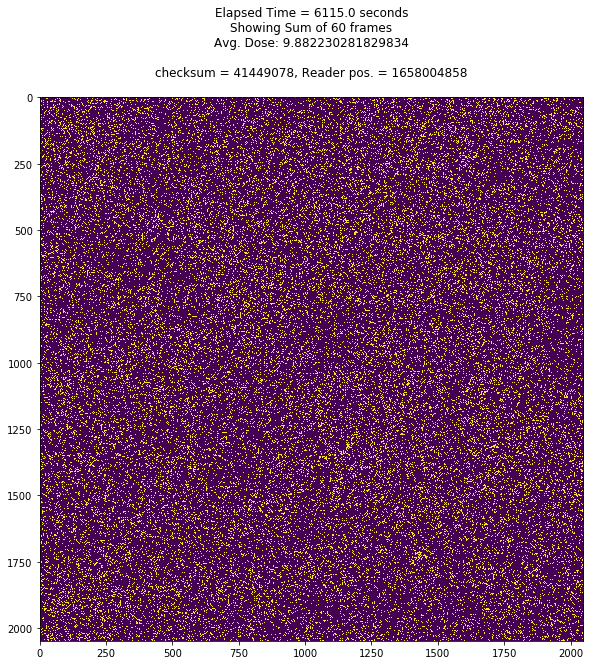

In [ ]:
_data_folder = '/scratch/loh/abhik/2Sep2020/live_view_test'
_dataset = ''
_tag = 'streampix_2k_60fps_run_4'
_num_part_files = 10
_frames_per_fetch = 60
_frames_per_second = 60

viewer = ReCoDeViewer(os.path.join(_data_folder, _dataset), _tag + '.rc1', _num_part_files, 0.1)
viewer.start()

time_step = 0
time_point = 0

_shape = viewer.get_shape()
n_pixels = _shape[0]*_shape[1]
print("Reader ready, shape =", _shape)

frame_index = 0
reader_zero_positions = []

view = np.zeros(_shape, dtype=np.uint16)
while True:
    
    frames = viewer.get_next_batch(_frames_per_fetch)
    p = viewer.get_position()
    reader_zero_positions.append(p)
    
    if frames is not None and len(frames) > 0:
        view = np.zeros(_shape, dtype=np.uint16)
        for frame in frames:
            frame_id = list(frame.keys())[0]
            frame_data = frame[frame_id]['data'].todense()
            view = np.add(view, frame_data)

        n_frames = len(frames)
        is_stale = ''
        frame_index += len(frames)
        has_data = True
    else:
        is_stale = '\nWaiting for data...'
        has_data = False
    
    checksum = np.sum(view)
    avg_dose = checksum*1.0/n_pixels
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(view, vmax=1)
    t = time_step * _frames_per_second/_frames_per_fetch
    title_str = 'Elapsed Time = ' + str(t) +  ' seconds' + \
                '\nShowing Sum of ' + str(n_frames) + ' frames' + \
                '\nAvg. Pixel Intensity: ' + str(avg_dose) + '\n' + \
                '\nchecksum = ' + str(checksum) + ', Reader pos. = ' + str(p) + '\n' + is_stale
                
    
    ax.set(title=title_str)
    # fig.colorbar(im)
    plt.show()
    clear_output(wait=True)
    
    if has_data:
        time_step += 1

In [88]:
for p in reader_zero_positions:
    print(p)

0
0
0
0
0
0
0
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1536
1